# Bootstrapping p values

This is a Jupyter notebook having two purposes.

1. Explain how to get bootstrap p values 

2. Show how blazingly fast Python is for this kind of tasks

## The bootstrap

The bootstrap is a resampling technique introduced by Bradley Efron in 1979 as a tool to find standard errors and confidence intervals in settings where we 

- do not have a standard error at hand for the given estimator (because it is too complex) or

- think that assumptions behind the usual standard error are grossly violated.

If you are not yet familiar with this technique, check <a href="https://en.wikipedia.org/wiki/Bootstrapping_(statistics)" >Wikipedia</a>. 

How do you e.g. calculate the bootstrap standard error of the sample mean of $n$ observations $X_1, \dots, X_n$?
1. Calculate the sample mean $\bar X$
2. Draw with replacement $n$ observations from the sample $X_1, \dots, X_n$. This is your first bootstrap sample. Repeat this over and over to end up with $B$ bootstrap samples. Choose $B$ as large as possible, e.g. 10'000. The whole point of the bootstrap is that such bootstrap sample is to the original sample as the sample is to the population.
3. For each bootstrap sample, calculate the sample mean $\bar X_i^b$. These values form your bootstrap sampling distribution.

The sample standard deviation $S$ of $\bar X_1^b, \dots, \bar X_B^b$ is often a reasonable guess for the true standard error of the mean. The interval $[\bar X \pm 1.96 S]$ is then an approximate 95%-confidence interval for the true population mean $\mu$. Alternatively, the percentage bootstrap confidence interval can be calculated, which is just the range from the 2.5% quantile up to the 97.5% quantile of the values $\bar X_i^b$. These are just simple bootstrap confidence intervals. There are clearly better versions around, no question. But our focus today is on something more delicate: p values.

## Illustration of the technique in Python

As an illustration, we will now implement in Python the bootstrap for the mean. To do so, we first load necessary modules and define two functions. The first generates all bootstrap samples. The second computes different confidence intervals, the standard error as well as a histogram of the bootstrap sampling distribution.

In [181]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

def boot_matrix(z, B):
    """Bootstrap sample
    
    Returns all bootstrap samples in a matrix"""
    
    n = len(z)  # sample size
    idz = np.random.randint(0, n, size=(B, n))  # indices to pick for all boostrap samples
    return z[idz]

def bootstrap_mean(x, B=10000, alpha=0.05, plot=False):
    """Bootstrap standard error and (1-alpha)*100% c.i. for the population mean
    
    Returns bootstrapped standard error and different types of confidence intervals"""
   
    # Deterministic things
    n = len(x)  # sample size
    orig = x.mean()  # sample mean
    se_mean = x.std()/np.sqrt(n) # standard error of the mean
    qt = stats.t.ppf(q=1 - alpha/2, df=n - 1) # Student quantile
    
    # Generate boostrap distribution of sample mean
    xboot = boot_matrix(x, B=B)
    sampling_distribution = xboot.mean(axis=1)
   
   # Standard error and sample quantiles
    se_mean_boot = sampling_distribution.std()
    quantile_boot = np.percentile(sampling_distribution, q=(100*alpha/2, 100*(1-alpha/2)))
 
    # RESULTS
    print("Estimated mean:", orig)
    print("Classic standard error:", se_mean)
    print("Classic student c.i.:", orig + np.array([-qt, qt])*se_mean)
    print("\nBootstrap results:")
    print("Standard error:", se_mean_boot)
    print("t-type c.i.:", orig + np.array([-qt, qt])*se_mean_boot)
    print("Percentile c.i.:", quantile_boot)
    print("Basic c.i.:", 2*orig - quantile_boot[::-1])

    if plot:
        plt.hist(sampling_distribution, bins="fd")   

Let's use this function to calculate different bootstrap 95%-confidence intervals for the true mean of a right skewed sample.

Estimated mean: 18.6554418641
Classic standard error: 4.0056616722
Classic student c.i.: [ 10.46294388  26.84793985]

Bootstrap results:
Standard error: 4.04023800375
t-type c.i.: [ 10.39222734  26.91865639]
Percentile c.i.: [ 11.31098768  27.29290141]
Basic c.i.: [ 10.01798232  25.99989605]


<IPython.core.display.Javascript object>


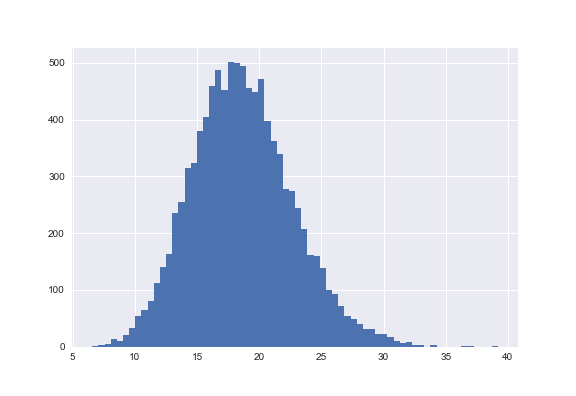

Wall time: 253 ms


In [182]:
np.random.seed(984564) # for reproducability
x = np.random.exponential(scale=20, size=30)
%time bootstrap_mean(x, plot=True)

In a two-sample setting (e.g. comparing two means), bootstrap samples would be drawn in each sample separately. This will handle e.g. the case of unequal variances.

### p values via bootstrap

Due to its simplicity, researchers are tempted also in finding p values by the bootstrap. Often a bad idea:
- Almost always, permutation tests are the way to go if we do not trust classic tests. An exception is when the observations cannot be assumed to be exchangable under the null, e.g. in a two-sample t-test situation with unequal variances.

- Often, classic tests (e.g. Welch's two-sample t test) are quite robust even to clear violations of assumptions.

- They think the bootstrap is a small sample technique where in fact its validity is usually only known in Asymptotica.

- **They do it wrongly**. 

What do I mean by the last bullet point? Look at the following algorithm:

1. Calculate original value of the test statistic $T_0$

2. Draw $B$ boostrap samples

3. For each bootstrap sample, calculate the test statistic $T_i$. The values $T_1, ..., T_B$ form the (boostrap) sampling distribution used in subsequent steps.

4. Calculate the proportion $\hat p$ of values in $T_1, ..., T_B$ at least as large as $T_0$. In a two-sided setting, the p value is $2 \cdot \min\{\hat p, 1-\hat p\}$.

My completely unqualified guess is that 80% of all bootstrap p values are calculated like this. The problem is hidden in Step 3 and we need to modify just this step: The boostrap sampling distribution is centered approximately around $T_0$ instead of 0 (or whatever value is associated with the null hypothesis). This is not what we need. Remember that p values are derived from sampling distributions *under the null hypothesis*. The trick is to modify the sample in Step 3 to make the null hypothesis hold. This is not always easy but in a two-sample t test setting, you would just subtract the group means from each value to end up with two samples with equal mean (0). Similar in a k-sample comparison setting: just subtract the location estimate of interest from each sample. 

An excellent reference is [Boos & Brownie (1988)](https://pdfs.semanticscholar.org/ba4e/96f388ee8fc03e78779ba1d1a303174e420c.pdf):

- It explains in detail how to find p values by the bootstrap
- It uses awesome tricks in Monte-Carlo simulation
- It compares performance of different two- and k-sample tests under different settings

We will focus now on the comparison of two means. Different test statistics can be used, e.g. 

1. The mean difference
2. The classic t-test statistic, i.e. the normalized mean difference
3. <a href = "https://en.wikipedia.org/wiki/Welch%27s_t-test"> Welch's t test statistic</a>, which uses a different normalization than the classic t-test statistic.

In the paper cited above, the authors recommend to use the third test statistic if the bootstrap is to be used. It had best performance regarding type I and II errors among the other procedures in consideration.  

So let's implement the bootstrap p value for Welch's t-test statistic. 

## Python for calculating bootstrap p values

Let's have a look at the function `bootstrap_t_pvalue`. It takes two samples and returns the bootstrap p value along with some other relevant information like the results of the classic t-test.

In [183]:
def bootstrap_t_pvalue(x, y, equal_var=False, B=10000, plot=False):
    """Bootstrap p values for two-sample t test
    
    Returns boostrap p value, test statistics and parametric p value"""
    
    # Original t test statistic
    orig = stats.ttest_ind(x, y, equal_var=equal_var)
    
    # Generate boostrap distribution of t statistic
    xboot = boot_matrix(x - x.mean(), B=B) # important centering step to get sampling distribution under the null
    yboot = boot_matrix(y - y.mean(), B=B)
    sampling_distribution = stats.ttest_ind(xboot, yboot, axis=1, equal_var=equal_var)[0]

    # Calculate proportion of bootstrap samples with at least as strong evidence against null    
    p = np.mean(sampling_distribution >= orig[0])
    
    # RESULTS
    print("p value for null hypothesis of equal population means:")
    print("Parametric:", orig[1])
    print("Bootstrap:", 2*min(p, 1-p))
    
    # Plot bootstrap distribution
    if plot:
        plt.figure()
        plt.hist(sampling_distribution, bins="fd") 

### Example 1

Let us first have a look at a standard situation: We sample from two shifted normal distributions. In such setting, the classic t-test is definitively the test to apply, especially because we have equal variances. 

In [184]:
np.random.seed(984564) # for reproducability
x = np.random.normal(loc=11, scale=20, size=30)
y = np.random.normal(loc=15, scale=20, size=20)
%time bootstrap_t_pvalue(x, y)

p value for null hypothesis of equal population means:
Parametric: 0.227538071226
Bootstrap: 0.213
Wall time: 23 ms


Wow. 20 milliseconds for 10'000 bootstrap runs? Try to beat this in R... 

The bootstrap p value is similar to the one from Welch's t test for unequal variances. In both cases you would end up to say something like "at the 5% level of significant, we cannot claim the two means to be truely different".

What would we get in such situation with the wrong bootstrap approach, i.e. *without centering* the samples before drawing bootstrap samples?

In [186]:
def the_wrong_way(x, y, equal_var=False, B=10000):
    """Bootstrap p values for two-sample t test
    
    Returns tuple with boostrapped p value, test statistics and parametric p value"""
    
    # Original Welch's t test statistic
    orig = stats.ttest_ind(x, y, equal_var=equal_var)
    
    # Generate boostrap distribution of Welch's t statistic
    xboot = boot_matrix(x, B=B) # uncentered samples
    yboot = boot_matrix(y, B=B)
    sampling_distribution = stats.ttest_ind(xboot, yboot, axis=1, equal_var=equal_var)[0]

    # Calculate proportion of bootstrap samples with at least as strong evidence against null    
    p = np.mean(sampling_distribution >= orig[0])
    
    # RESULTS
    print("Don't do like this...")
    print("p value for null hypothesis of equal population means")
    print("Parametric:", orig[1])
    print("Bootstrap:", 2*min(p, 1-p))

In [187]:
the_wrong_way(x, y)

Don't do like this...
p value for null hypothesis of equal population means
Parametric: 0.227538071226
Bootstrap: 0.9804


Just look at this bootstrap p value. So wrong.

### Example 2

Now, just to show how well Welch's t-test for unequal variances works

p value for null hypothesis of equal population means:
Parametric: 0.202797457459
Bootstrap: 0.215


<IPython.core.display.Javascript object>


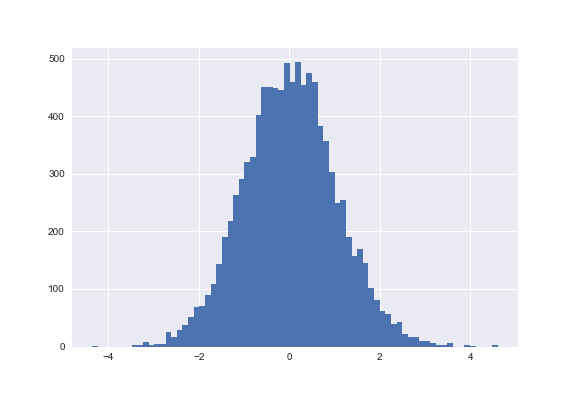

In [188]:
np.random.seed(345244) # for reproducability
x = np.random.normal(loc=11, scale=20, size=30)
y = np.random.normal(loc=15, scale=10, size=20)
bootstrap_t_pvalue(x, y, plot=True)

### Example 3

Let's move on to the nasty situation: Unequal variances, non-normality

p value for null hypothesis of equal population means:
Parametric: 0.041263608229
Bootstrap: 0.0288


<IPython.core.display.Javascript object>


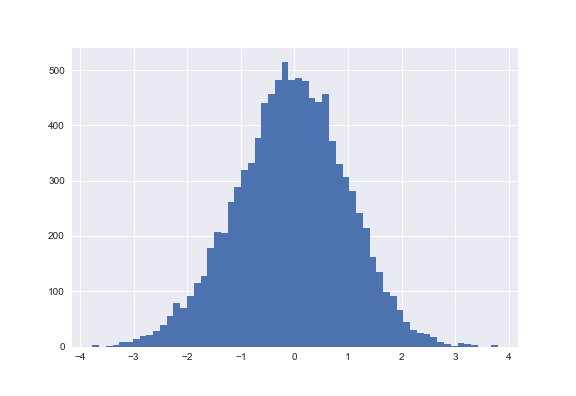

In [189]:
np.random.seed(399888) # for reproducability
x = np.random.exponential(scale=20, size=30)
y = np.random.exponential(scale=10, size=20)
bootstrap_t_pvalue(x, y, plot=True)

Here, we can see quite some difference. We don't know the "correct" p value. To do so, we would need to do a full fledged Monte-Carlo-Study. Maybe I will do that in the next notebook?